In [175]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpmath
import struct
import json
from matplotlib import cm # colormaps
# from numba import jit
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [176]:
def ellippi(n, m):
    return sp.special.elliprf(0., 1. - m, 1.) + (n / 3.) * sp.special.elliprj(0., 1. - m, 1., 1. - n)

In [177]:
M = 1
G = 6.67430e-11

class Ring():
    def __init__(self, name, radius_start, radius_end, mass=None, sigma0=None):
        self.name = name
        self.r0 = radius_start
        self.r1 = radius_end
        if sigma0:
            self.sigma0 = sigma0
            self.mass = sigma0 * (np.pi * radius_end**2 - np.pi * radius_start**2)
        else:
            self.mass = mass
            self.sigma0 = mass / (np.pi * radius_end**2 - np.pi * radius_start**2)

    def __str__(self):
        return f'{self.name}: {self.r0=}, {self.r1=}, with {self.mass=} and {self.sigma0=}'

ringc = Ring('Ring C', 74.658e6, 91.975e6, sigma0=40) 
ringb = Ring('Ring B', 91.975e6, 117.68e6, sigma0=700)
ringcd = Ring('Ring Cassini Division', 117.68e6, 122.17e6, sigma0=190)
ringa = Ring('Ring A', 122.17e6, 136.775e6, sigma0=300)

rings = [ringc, ringb, ringcd, ringa]
total_mass = sum([ring.mass for ring in rings])
print("Total mass = ", total_mass, " kg")

Total mass =  1.6421212058810935e+19  kg


In [178]:
json.dumps({ring.name:{'r0': ring.r0, 'r1': ring.r1, 'mass': ring.mass,} for ring in rings})

'{"Ring C": {"r0": 74658000.0, "r1": 91975000.0, "mass": 3.626131372286536e+17}, "Ring B": {"r0": 91975000.0, "r1": 117680000.0, "mass": 1.185142971124e+19}, "Ring Cassini Division": {"r0": 117680000.0, "r1": 122170000.0, "mass": 6.428202323626719e+17}, "Ring A": {"r0": 122170000.0, "r1": 136775000.0, "mass": 3.5643489779796096e+18}}'

In [179]:
# r0 = 92e6
# r1 = 117.68e6
# mass_bring = 10e18
# Sigma_0 = mass_bring / (np.pi * r1**2 - np.pi * r0**2) # sigma0: kg/m2

# Potential: simple ring
# def pot(R, z):
#     ring_dist2 = (R+a)**2 + z**2
    # return -2/np.pi * G*M/np.sqrt(ring_dist2) * sp.special.ellipk(4*R*a/ring_dist2)

# I_10 ^-1, use a = r_1|r_0, b = r, s = |z|; uses HP-format
def laplacian_besselproduct(a, b, s, ignore_quadrature=False):
    if a == 0:
        a = 1
    if b == 0:
        b = 1
    
    # Otherwise: divide by zero
    if s == 0:
        if b < a:
            return 2/np.pi * sp.special.ellipe((b/a)**2)
        else:
            return 2/np.pi * ((a/b-b/a) * sp.special.ellipk((a/b)**2) + b/a * sp.special.ellipe((a/b)**2))

    # Custom implementation for r < r_1, z != 0
    if b <= a and s != 0:
        return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=500)[0]

    A = np.sqrt((a+b)**2 + s**2)
    B = np.sqrt((a-b)**2 + s**2)
    L1 = (A-B)/2
    L2 = (A+B)/2
    k = L1/L2

    E = sp.special.ellipe(k**2)
    K = sp.special.ellipk(k**2)

    if a < b: # r_1/r_0 < r
        # Original implementation, only run if ignore_quadrature=True
        # if ignore_quadrature:
        n_ab = k*a/b
        PI_ab = ellippi(n_ab, k**2)
        return 2*L2/(np.pi*a) * (E - K + a**2/L2**2 * K + s**2/L2**2 * (K - PI_ab))
        # else:
        #     return sp.integrate.quad(besselproduct_integrand, 0, np.inf, args=(a, b, s), limit=500)[0]
    else:
        n_ba = k*b/A
        PI_ba = ellippi(n_ba, k**2)
        return 2*L2/(np.pi*a) * (E - K + a**2/L2**2 * K + s**2/L2**2 * (PI_ba - np.pi*L2/(2*s)))

# using ENS-4.6
def laplacian_besselproduct_ens(a, b, s):
    if a == 0:
        a = 0.00001
    if b == 0:
        b = 0.00001
    
    # Otherwise: divide by zero
    if s == 0:
        if b < a:
            return 2/np.pi * sp.special.ellipe((b/a)**2)
        else:
            return 2/np.pi * ((a/b-b/a) * sp.special.ellipk((a/b)**2) + b/a * sp.special.ellipe((a/b)**2))
    
    kappa = 2*np.sqrt(a*b/((a+b)**2 + s**2))
    nu = 4*a*b/((a+b)**2)
    K = sp.special.ellipk(kappa**2)
    E = sp.special.ellipe(kappa**2)
    Lambda = np.abs(a - b)/(a + b) * s/np.sqrt((a+b)**2 + s**2) * ellippi(nu, kappa)
    return 1/(np.pi * a) * (2*np.sqrt(a*b)/kappa * E + (a**2 - b**2) * kappa/(2*np.sqrt(a*b)) * K) \
        + s/(np.pi * a) * np.sign(a - b) * Lambda  - s/a * np.heaviside(a - b, 1)

def besselproduct_integrand(x, a, b, s):
    return 1/x * sp.special.jv(1, a*x) * sp.special.jv(0, b*x) * np.exp(-np.abs(s)*x)

def besselproduct_integrand_usub(u, a, b, s): # use u-sub: u=bx to integrate small values
    return 1/u * sp.special.jv(1, a*u/b) * sp.special.jv(0, u) * np.exp(-np.abs(s) * u/b)

# def laplacian_besselproduct_quadrature(a, b, s):
def laplacian_besselproduct_quadrature(a, b, s, limit=500):
    if a == 0:
        return 0
    return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=limit)[0]

# Potential: annulus
def pot(R, z, ring, quadrature=False):
    laplace_r1 = 0
    laplace_r0 = 0
    if quadrature:
        laplace_r1 = ring.r1 * laplacian_besselproduct_quadrature(ring.r1, R, abs(z))
        laplace_r0 = ring.r0 * laplacian_besselproduct_quadrature(ring.r0, R, abs(z))
    else:
        laplace_r1 = ring.r1 * laplacian_besselproduct(ring.r1, R, abs(z))
        laplace_r0 = ring.r0 * laplacian_besselproduct(ring.r0, R, abs(z))
    return 2 * np.pi * G * ring.sigma0 * (laplace_r1 - laplace_r0)

def pot_rings(R, z, quadrature=False):
    return np.sum([pot(R, z, ring, quadrature=quadrature) for ring in rings])

def force_cyl_approx(R, z, dR, dz):
    pot_point = np.vectorize(pot_rings)(R, z)
    diff_R = (pot_rings(R+dR, z) - pot_point)/dR
    diff_z = (pot_rings(R, z+dz) - pot_point)/dz
    return (-diff_R, 0, -diff_z)

def force_xyz_approx(x, y, z, dR, dz):
    R = np.sqrt(x**2 + y*2)
    phi = np.atan2(y, x)
    force_cyl = force_cyl_approx(R, z, dR, dz)

    matrix = np.array([[np.cos(phi), -np.sin(phi), 0],
                      [np.sin(phi), np.cos(phi), 0],
                      [0, 0, 1]])
    
    return np.linalg.matmul(matrix, force_cyl) # cylinder -> xyz

# assume y = 0 since axisymmetric
def force_xyz_approx_y0(x, z, dR, dz):
    R = x
    phi = 0
    force_cyl = force_cyl_approx(R, z, dR, dz)

    matrix = np.array([[1, 0, 0],
                      [0, 1, 0],
                      [0, 0, 1]])
    
    return np.linalg.matmul(matrix, force_cyl) # cylinder -> xyz

Max error elliptical-quadrature = 2.0813458179169686e-09
Max error integration = 1.4766245942985139e-08


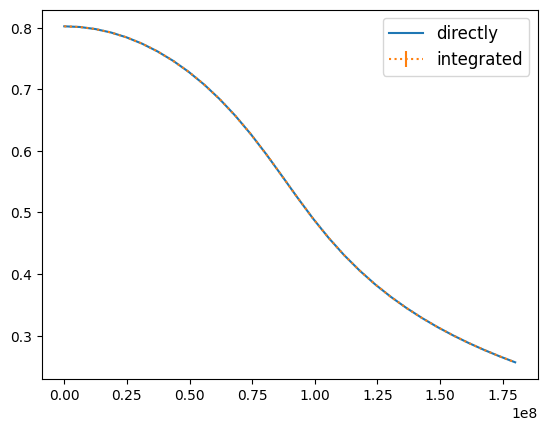

In [197]:
center = 90e6
r = np.linspace(3_000, 2*center, 30)
z = 20e6
directly = np.array([laplacian_besselproduct(center, r_v, z, ignore_quadrature=True) for r_v in r])
# print(f"{directly=}")

integrated = np.array(
    [sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(center, r_v, z), limit=500)
     for r_v in r])

error = [integrated[k][1] for k in range(len(integrated))]
integrated = [integrated[k][0] for k in range(len(integrated))]
# print(f"{integrated=}")

print(f"Max error elliptical-quadrature = {max(directly-integrated)}")
print(f"Max error integration = {max(error)}")
# plt.errorbar(r, directly-integrated, yerr=error, label='difference', ls='dotted', marker='o')
plt.plot(r, directly, label='directly')
# plt.plot(r, integrated, label='integrated')
plt.errorbar(r, integrated, yerr=error, label='integrated', ls='dotted')
# plt.xlim(0, 0.4)
# plt.ylim((1-0.01, 1+0.01))
plt.legend()
plt.show()

## Graphics

### project images

In [182]:
def derivative_at(r0, z0, dr=1e3):
    return (pot_rings(r0+dr, z0)-pot_rings(r0, z0))/dr

def derivative_at_dz(r0, z0, dz=1e3):
    return (pot_rings(r0, z0+dz)-pot_rings(r0, z0))/dz

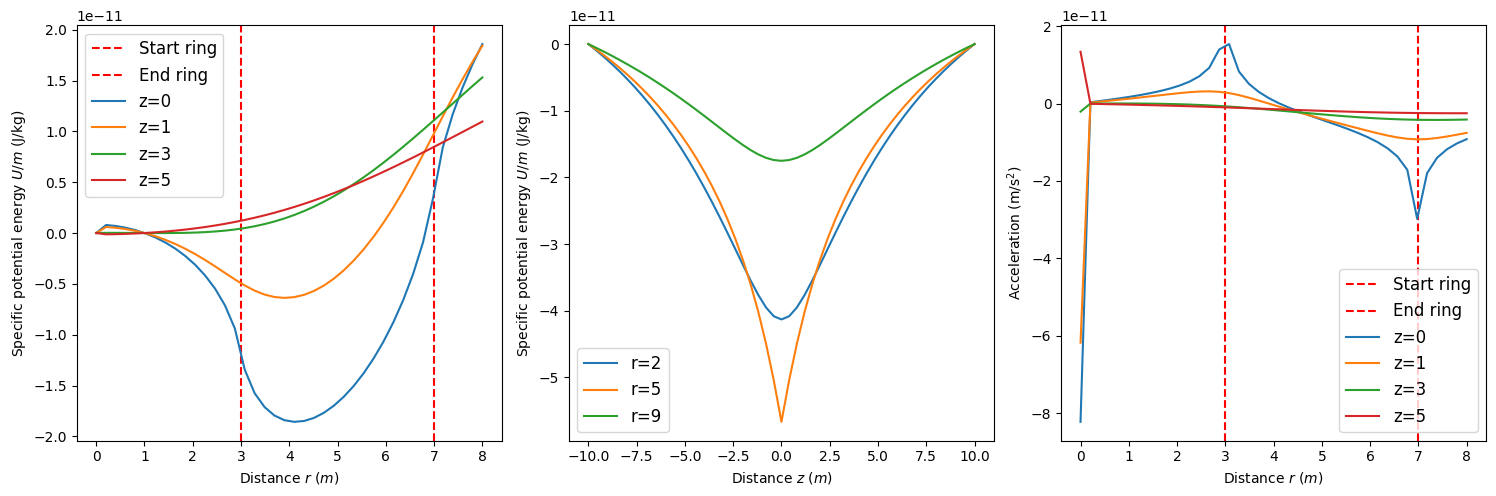

In [183]:
test_ring = Ring('Test ring', 3, 7, mass=5)
test_r = np.linspace(0, 8, 40)
z_items = [0, 1, 3, 5]
test_pot = [np.array([pot(r, z_v, test_ring) for r in test_r]) for z_v in z_items]
test_specific_energy = [test_pot[k][0] - test_pot[k] for k in range(len(z_items))]
# test_z = np.linspace(-5, 5, 101)

def __derivative_at_ring(r0, z0, ring, dr=0.01):
    return (pot(r0+dr, z0, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dr

def __derivative_at_ring_dz(r0, z0, ring, dz=0.1):
    return (pot(r0, z0+dz, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dz

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax1.set_xlabel('Distance $r$ ($m$)')
ax1.set_ylabel('Specific potential energy $U/m$ (J/kg)')
ax1.axvline(3, ls='--', color='red', label='Start ring')
ax1.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    ax1.plot(test_r, test_specific_energy[i], label=f'z={z_items[i]}')
ax1.legend()


test_z = np.linspace(-10, 10, 51)
r_items = [2, 5, 9]
test_pot_z = [np.array([pot(r_v, z, test_ring) for z in test_z]) for r_v in r_items]
test_specific_energy_z = [test_pot_z[k][0] - test_pot_z[k] for k in range(len(r_items))]
ax2.set_xlabel('Distance $z$ ($m$)')
ax2.set_ylabel('Specific potential energy $U/m$ (J/kg)')
for i in range(len(r_items)):
    ax2.plot(test_z, test_specific_energy_z[i], label=f'r={r_items[i]}')
ax2.legend()


ax3.axvline(3, ls='--', color='red', label='Start ring')
ax3.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    accel_r = np.array([__derivative_at_ring(r0, z_items[i], test_ring) for r0 in test_r])
    accel_z = np.array([__derivative_at_ring_dz(r0, z_items[i], test_ring) for r0 in test_r])
    accel = np.sqrt(accel_r**2 + accel_z**2)
    ax3.plot(test_r, accel_r, label=f'z={z_items[i]}')

# ax2.plot(test_r, accel)
# ax2.plot(test_r, [__derivative_at_ring(r0, 0, test_ring) for r0 in test_r])
ax3.set_xlabel('Distance $r$ ($m$)')
ax3.set_ylabel('Acceleration (m/s$^2$)')

ax3.legend()

fig.tight_layout()
fig.savefig('./images/plot_potential.pdf')
# plt.show()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_12500\168768492.py:27: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=500)[0]


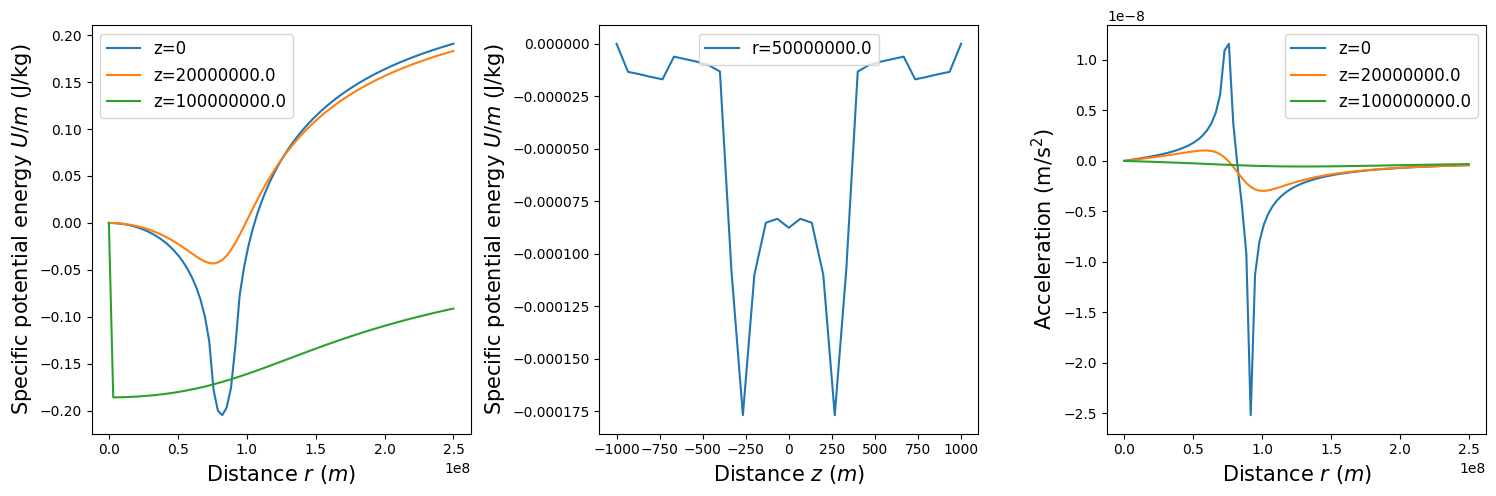

In [200]:
# test_ring = Ring('Test ring', 3, 7, mass=5)
test_r = np.linspace(10_000, 2.5e8, 80)
z_items = [0, 20e6, 100e6]
test_pot = [np.array([pot(r, z_v, rings[0]) for r in test_r]) for z_v in z_items]
# test_pot = [np.array([sum([pot(r, z_v, ring) for ring in rings]) for r in test_r]) for z_v in z_items]
test_specific_energy = [test_pot[k][0] - test_pot[k] for k in range(len(z_items))]

# test_z = np.linspace(-5, 5, 101)

def __derivative_at_ring(r0, z0, ring, dr=0.01):
    return (pot(r0+dr, z0, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dr

def __derivative_at_ring_dz(r0, z0, ring, dz=0.1):
    return (pot(r0, z0+dz, ring, quadrature=False) - pot(r0, z0, ring, quadrature=False))/dz

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=15)     # fontsize of the axes title
plt.rc('axes', labelsize=15)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

ax1.set_xlabel('Distance $r$ ($m$)')
ax1.set_ylabel('Specific potential energy $U/m$ (J/kg)')
# ax1.axvline(3, ls='--', color='red', label='Start ring')
# ax1.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    ax1.plot(test_r, test_specific_energy[i], label=f'z={z_items[i]}')
ax1.legend()


test_z = np.linspace(-1e3, 1e3, 31)
r_items = [0.5e8]
test_pot_z = [np.array([sum([pot(r_v, z, ring) for ring in rings]) for z in test_z]) for r_v in r_items]
test_specific_energy_z = [test_pot_z[k][0] - test_pot_z[k] for k in range(len(r_items))]
ax2.set_xlabel('Distance $z$ ($m$)')
ax2.set_ylabel('Specific potential energy $U/m$ (J/kg)')
for i in range(len(r_items)):
    ax2.plot(test_z, test_specific_energy_z[i], label=f'r={r_items[i]}')
ax2.legend()


# ax3.axvline(3, ls='--', color='red', label='Start ring')
# ax3.axvline(7, ls='--', color='red', label='End ring')
for i in range(len(z_items)):
    accel_r = np.array([__derivative_at_ring(r0, z_items[i], rings[0]) for r0 in test_r])
    accel_z = np.array([__derivative_at_ring_dz(r0, z_items[i], rings[0]) for r0 in test_r])
    accel = np.sqrt(accel_r**2 + accel_z**2)
    ax3.plot(test_r, accel_r, label=f'z={z_items[i]}')

# ax2.plot(test_r, accel)
# ax2.plot(test_r, [__derivative_at_ring(r0, 0, test_ring) for r0 in test_r])
ax3.set_xlabel('Distance $r$ ($m$)')
ax3.set_ylabel('Acceleration (m/s$^2$)')

ax3.legend()

fig.tight_layout()
# fig.savefig('./images/plot_potential.pdf')
plt.show()

### actual analysis

In [10]:
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [11]:
# x = np.linspace(0, 2, 20)
# z_z = np.linspace(-5, 5, 11)

# X, Z_Z = np.meshgrid(x, z_z)

# def length_force(x0, z0):
#     force = force_xyz_approx(x0, 0, z0, 0.01, 0.01)
#     length = np.sqrt(np.dot(force, force))
#     if force[0] < 0: # with R direction
#         length *= -1
#     return length

# forces = np.zeros((len(x), len(z_z)))

# for i in range(len(x)):
#     for j in range(len(z_z)):
#         r0 = x[i]
#         z0 = z_z[j]
#         forces[i, j] = length_force(r0, z0)

# plt.xlabel('x')
# plt.ylabel('z')
# plt.contourf(X, Z_Z, forces.T.clip(max=10), 50)
# plt.colorbar()

# plt.show()

In [214]:
# R = np.linspace(5e8, 10e9, 500) # 50e6, 500e6

# R = np.linspace(1e6, 5e8, 40) # 500
R = np.linspace(1e6, 5e8, 200) # 500

# R = np.linspace(5e8, 100e8, 30)
# approximation GM/r from 5e7
z = np.linspace(-100e6, 100e6, 100+1) # 401
# z = np.linspace(-5, 0, 5, 3)

R_R, Z_Z = np.meshgrid(R, z)
# potential = pot(R, z)

### Forces

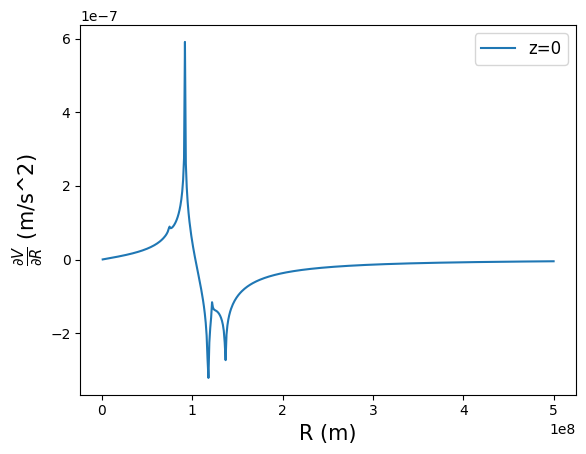

In [209]:
forces = [derivative_at(r, 0) for r in R]

plt.xlabel('R (m)')
plt.ylabel('$\\frac{\\partial V}{\\partial R}$ (m/s^2)')
plt.plot(R, forces, label='z=0')
# plt.plot(R[400:], forces[400:], label=f'z=0')
# plt.plot(R[400:], -1*G*mass_bring/((R[400:])**2), label=f'1/r2')
plt.legend()
plt.show()

C:\Users\Alexander\AppData\Local\Temp\ipykernel_17600\3639130014.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(R[5:], ((forces + 1*G* total_mass / ((R)**2))/forces*100)[5:], label=f'z=0')


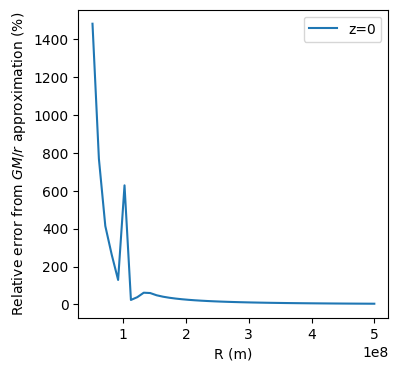

In [ ]:
# Zet dit in de appendix
# forces = [derivative_at(r, 0) for r in R]

plt.figure(figsize=(4,4))

plt.xlabel('R (m)')
plt.ylabel('Relative error from $GM/r$ approximation (%)')
plt.plot(R[5:], ((forces + 1*G* total_mass / ((R)**2))/forces*100)[5:], label=f'z=0')
# plt.plot(R[400:], , label=f'1/r2')

plt.legend()
# plt.savefig('./images/plot gmr approx.pdf')
plt.show()

In [215]:
# forces: derivative in R, forces_z: derivative in Z
forces = np.zeros((len(R), len(z)))
forces_z = np.zeros((len(R), len(z))) 

total_iterations = len(R)*len(z)

def generate_forces():
    for i in range(len(R)):
        for j in range(len(z)):
            cur_iter = j + i*len(R)
            if cur_iter % 500 == 0:
                print(f"{cur_iter/total_iterations*100:.2f}%")
            R0 = R[i]
            z0 = z[j]
            forces[i, j] = derivative_at(R0, z0)
            forces_z[i, j] = derivative_at_dz(R0, z0)

generate_forces()

0.00%


C:\Users\Alexander\AppData\Local\Temp\ipykernel_12500\168768492.py:27: IntegrationWarning: The maximum number of subdivisions (500) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return sp.integrate.quad(besselproduct_integrand_usub, 0, np.inf, args=(a, b, s), limit=500)[0]


2.48%
4.95%
7.43%
9.90%
12.38%
14.85%
17.33%
19.80%
22.28%
24.75%
27.23%
29.70%
32.18%
34.65%
37.13%
39.60%
42.08%
44.55%
47.03%
49.50%
51.98%
54.46%
56.93%
59.41%
61.88%
64.36%
66.83%
69.31%
71.78%
74.26%
76.73%
79.21%
81.68%
84.16%
86.63%
89.11%
91.58%
94.06%
96.53%
99.01%
101.49%
103.96%
106.44%
108.91%
111.39%
113.86%
116.34%
118.81%
121.29%
123.76%
126.24%
128.71%
131.19%
133.66%
136.14%
138.61%
141.09%
143.56%
146.04%
148.51%
150.99%
153.47%
155.94%
158.42%
160.89%
163.37%
165.84%
168.32%
170.79%
173.27%
175.74%
178.22%
180.69%
183.17%
185.64%
188.12%
190.59%
193.07%
195.54%


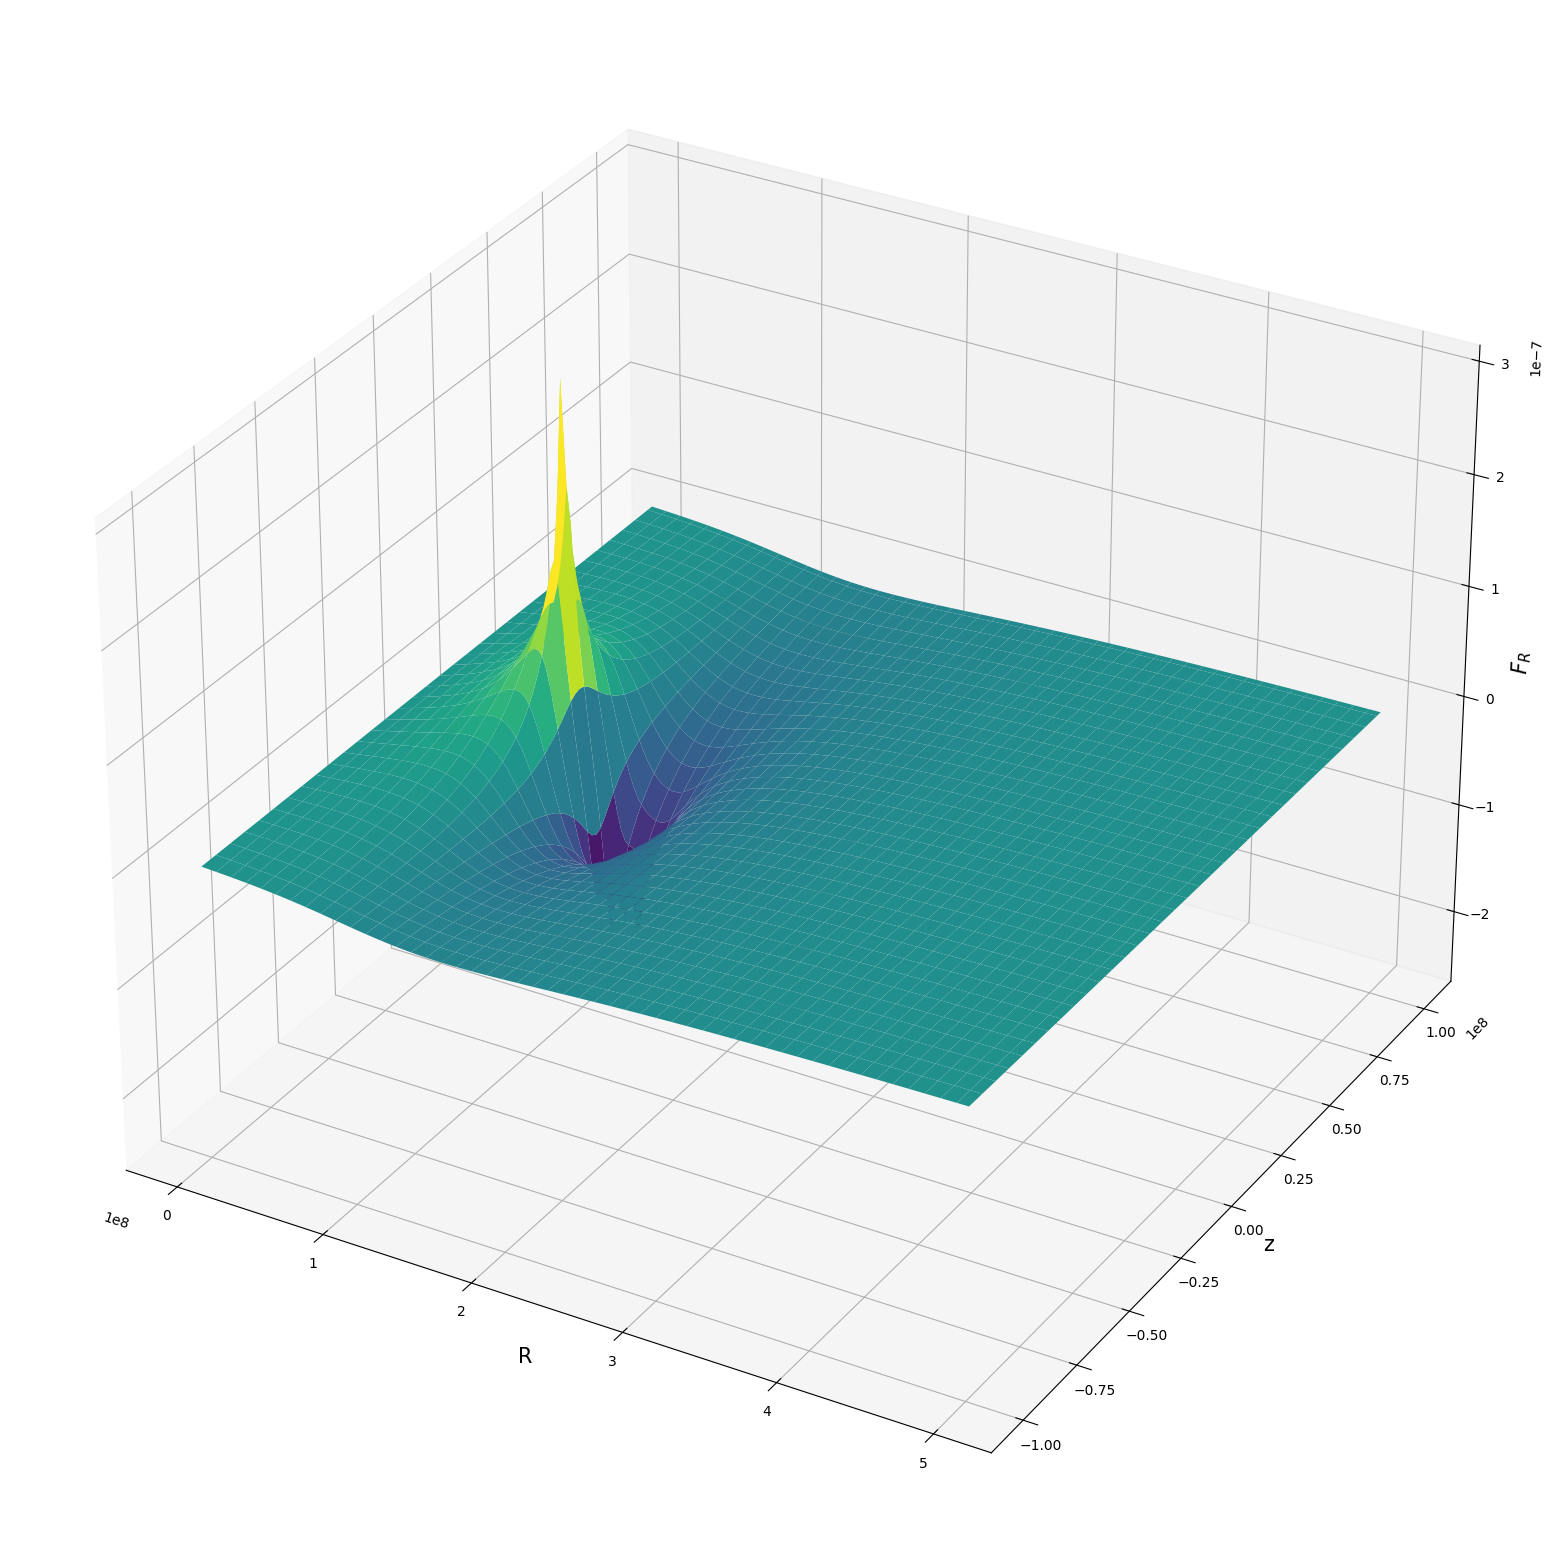

In [216]:
ax = plt.figure(figsize=(20, 20)).add_subplot(projection='3d')

ax.set_xlabel('R')
ax.set_ylabel('z')
ax.set_zlabel('$F_R$')

ax.plot_surface(R_R, Z_Z, forces.T, cmap=cm.viridis)

plt.show()

### Saving data

In [218]:
def save_as_binary(matrix, file):
    a, b = matrix.shape
    with open(file, 'wb') as f:
        for i in range(0, a):
            values = matrix[i, :]
            values = struct.pack(f'{b}d', *values)
            f.write(values)
            # for j in range(0, b):
            #     value = float(matrix[i][j])
            #     f.write(bytes())
        f.close()

    # print(a, b)


# save_as_binary(forces, f'forces_r_{len(R)}x{len(z)}.bin')
# save_as_binary(forces_z, f'forces_z_{len(R)}x{len(z)}.bin')

In [221]:
forces_testload = np.zeros((200, 101))

with open('forces_r_200x101.bin', 'rb') as f:
    for i in range(0, 200):
        values = f.read(8 * 101)
        forces_testload[i, :] = struct.unpack('101d', values)
        # for j in range(401):
        #     forces_testload[i][j] = float(bytes(f.read(4)))

# np.all(forces_testload == forces)

In [19]:
cur_pos = np.array([0.9e8 * np.cos(np.pi/4), 0.9e8 * np.cos(np.pi/4), 0.5e8])
cur_R = np.sqrt(cur_pos[0]**2 + cur_pos[1]**2)
calc_dR = 5e8/(500-1)
index_R = (int(np.floor(cur_R / calc_dR)), int(np.ceil(cur_R / calc_dR))) 
calc_dz = 200e6/(401-1)
index_z = (int(np.floor(cur_pos[2] / calc_dz)) + 200, int(np.ceil(cur_pos[2] / calc_dz)) + 200)

# print(index_R, index_z)

interp_R = (cur_R - R[index_R[0]])/calc_dR
interp_z = (cur_pos[2] - z[index_z[0]])/calc_dz

print(interp_R, interp_z)
print(index_z)

forces_R_points = [forces[index_R[0], index_z[0]], forces[index_R[1], index_z[0]],
                   forces[index_R[0], index_z[1]], forces[index_R[1], index_z[1]]]

forces_z_points = [forces_z[index_R[0], index_z[0]], forces_z[index_R[1], index_z[0]],
                   forces_z[index_R[0], index_z[1]], forces_z[index_R[1], index_z[1]]]

forces_R_halfway = [(forces_R_points[0] + forces_R_points[1])/2, (forces_R_points[2] + forces_R_points[3])/2]
forces_z_halfway = [(forces_z_points[0] + forces_z_points[1])/2, (forces_z_points[2] + forces_z_points[3])/2]
cur_forces_R = np.mean(forces_R_halfway)
cur_forces_z = np.mean(forces_z_halfway)

cur_force = np.array([
    cur_pos[0]/cur_R * cur_forces_R,
    cur_pos[1]/cur_R * cur_forces_R,
    cur_forces_z
])

print(cur_force)

IndexError: index 89 is out of bounds for axis 0 with size 50

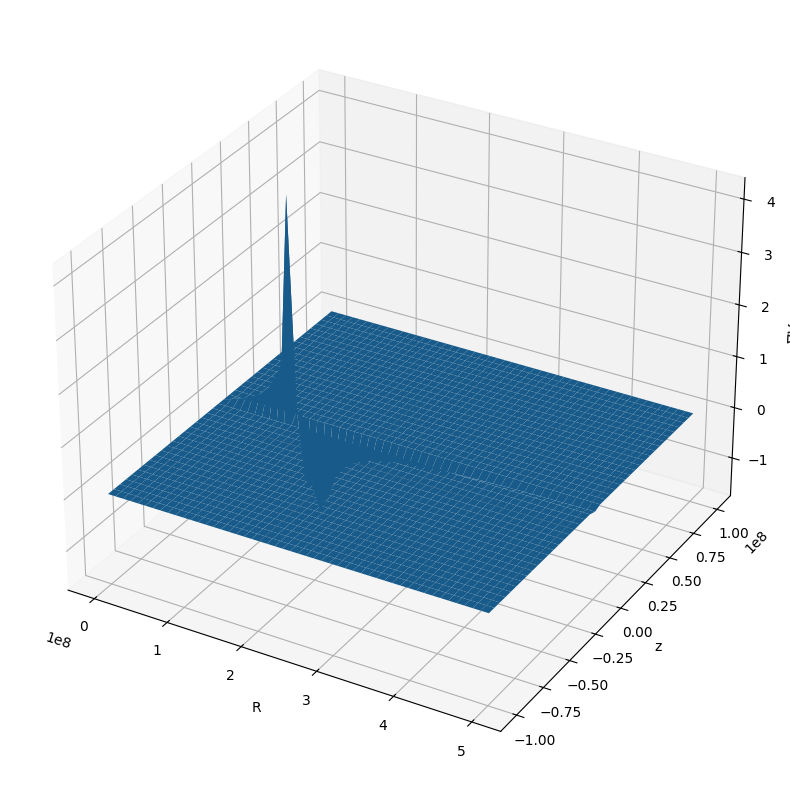

In [58]:
ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.set_xlabel('R')
ax.set_ylabel('z')
ax.set_zlabel('$\\nabla V$')

ax.plot_surface(R_R, Z_Z, forces.T)

plt.show()

In [125]:
# plt.xticks(R[:, 0], np.arange(0, 3, 1))
# plt.yticks(z[0, :], np.arange(-10, 10, 1))
# plt.imshow(potential)

plt.xlabel('R')
plt.ylabel('z')
plt.contourf(R, z, forces.T, 50)

# plt.axvline(r0)
# plt.axvline(r1)

plt.colorbar()

plt.show()

AttributeError: 'list' object has no attribute 'T'

### Potential

In [173]:
potential = np.zeros((len(R), len(z)))

# @jit(nopython=True, parallel=True)
def generate_potential():
    for i in range(len(R)):
        for j in range(len(z)):
            R0 = R[i]
            z0 = z[j]
            potential[i, j] = pot_rings(R0, z0, quadrature=False)

generate_potential()

# generate_potential.parallel_diagnostics(level=4)

C:\Users\Alexander\AppData\Local\Temp\ipykernel_12500\3409992728.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


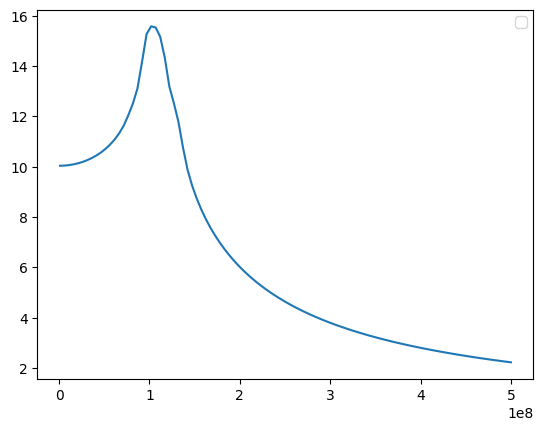

In [170]:
plt.plot(R, potential[:,10])
# for ring in rings:
#     plt.axvline(ring.r0, ls='--', label=f'{ring.name}: r0={ring.r0/1e8:.1f}e8')
#     plt.axvline(ring.r1, ls='-.', label=f'{ring.name}: r1={ring.r1/1e8:.1f}e8')

plt.legend()
plt.show()

In [148]:
rings

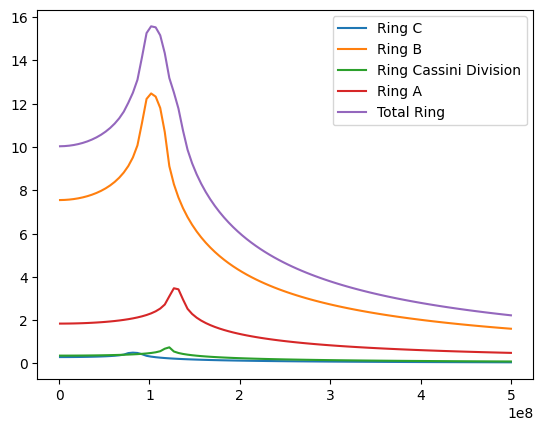

In [171]:
for ring in rings:
    test_pot = np.zeros_like(R)
    for i in range(len(R)):
        R0 = R[i]
        z0 = 0
        test_pot[i] = pot(R0, z0, quadrature=False, ring=ring)
        
    plt.plot(R, test_pot, label=f'{ring.name}')

plt.plot(R, potential[:,10], label='Total Ring')
plt.legend()
plt.show()

In [ ]:
# %lprun -f generate_potential -f pot -f laplacian_besselproduct generate_potential()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (41, 50) and arg 2 with shape (21, 500).

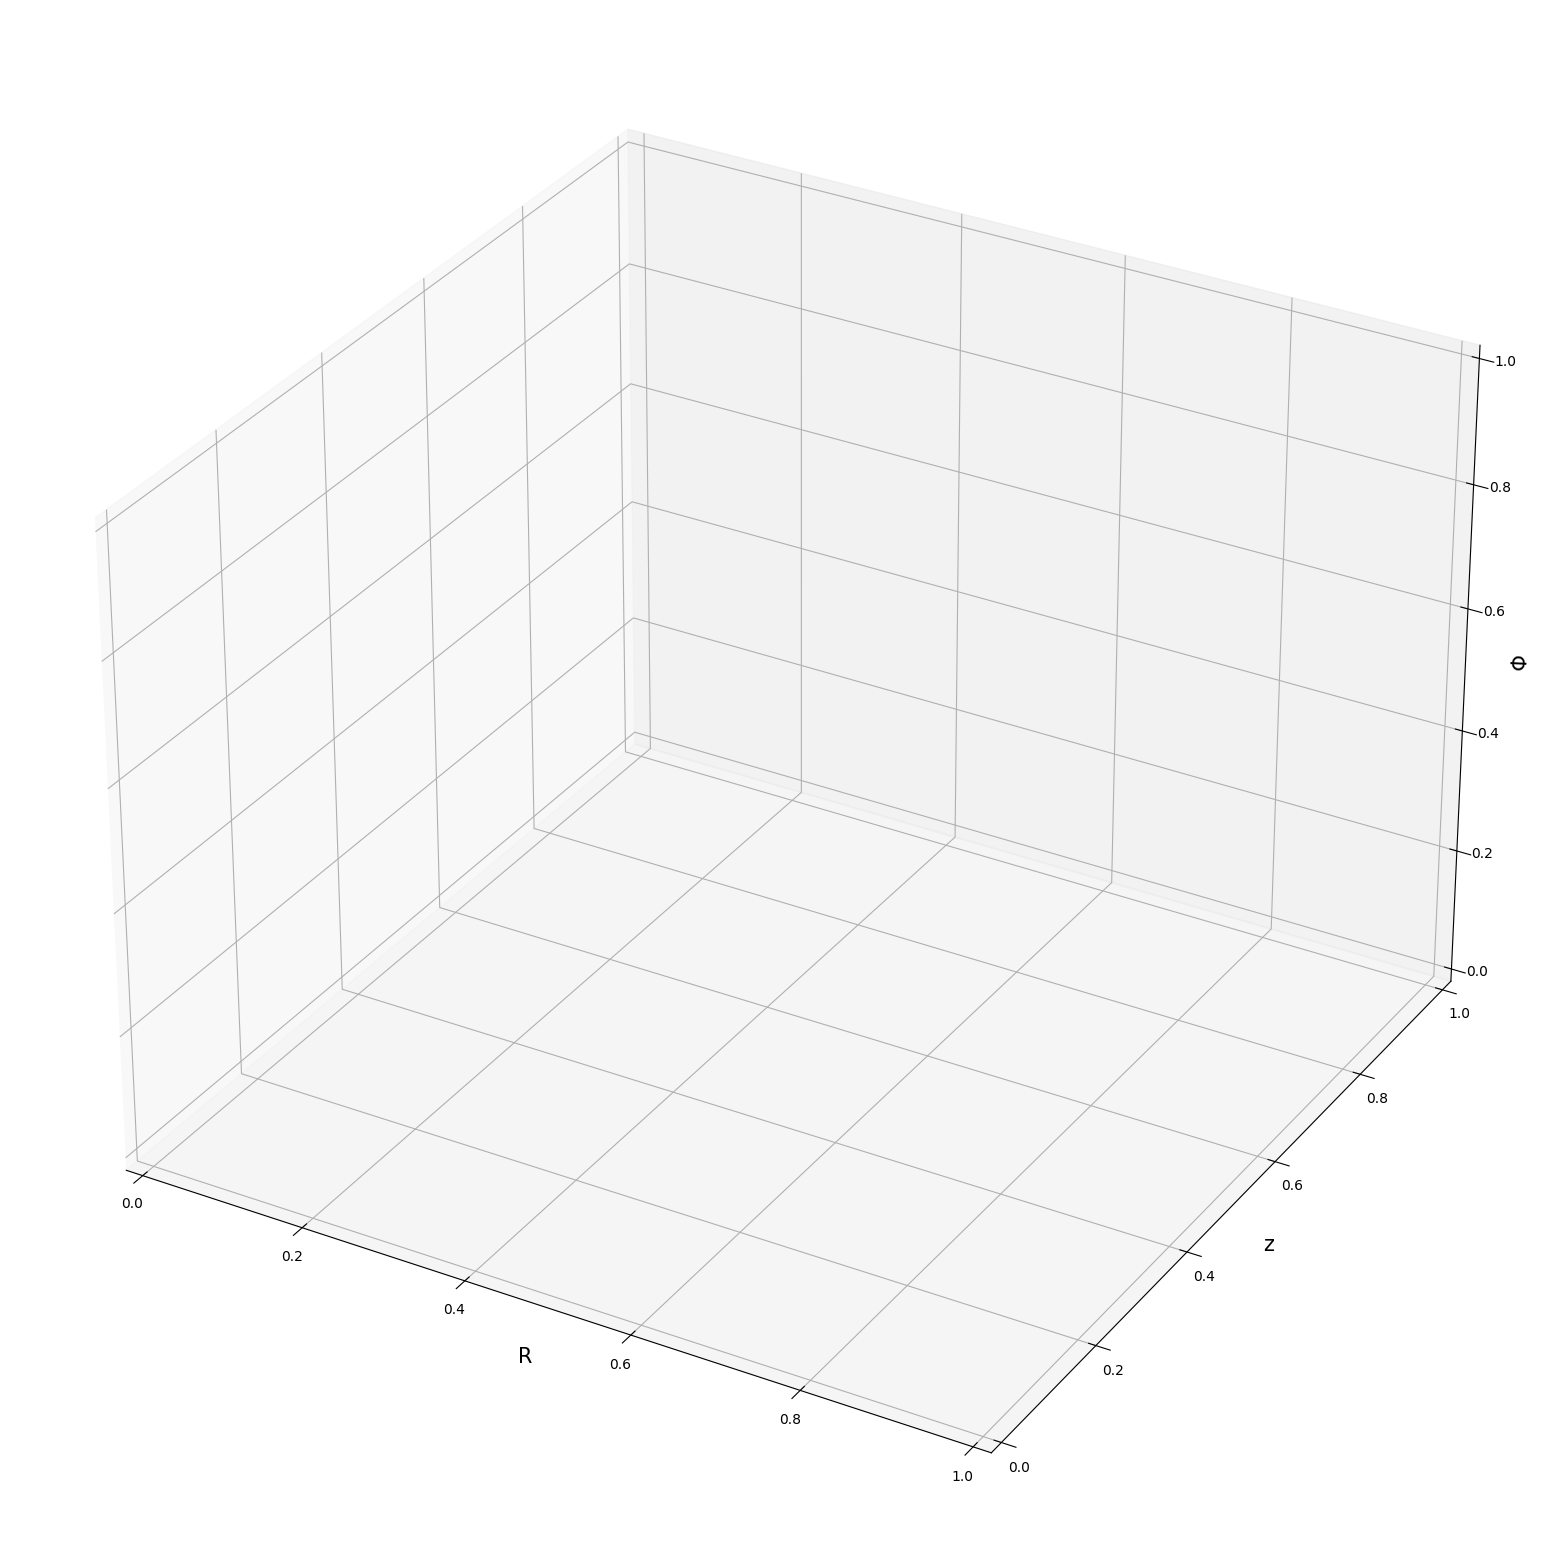

In [205]:
ax = plt.figure(figsize=(20, 20)).add_subplot(projection='3d')

ax.set_xlabel('R')
ax.set_ylabel('z')
ax.set_zlabel('$\\Phi$')

ax.plot_surface(R_R, Z_Z, potential.T, cmap=cm.viridis)

plt.show()

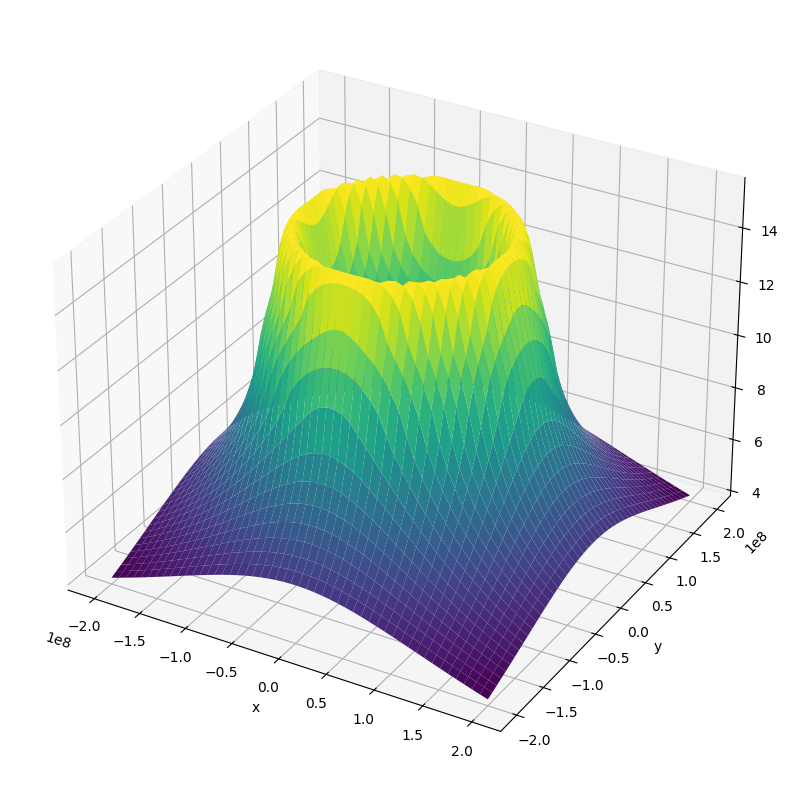

In [164]:
X = np.linspace(-2e8, 2e8, 50)
Y = np.copy(X)
potential_xy = np.zeros((len(X), len(Y)))

# @jit(nopython=True, parallel=True)
for i in range(len(X)):
    for j in range(len(Y)):
        x = X[i]
        y = Y[j]
        R0 = np.sqrt(x**2 + y**2)
        z0 = 0
        potential_xy[i, j] = pot_rings(R0, z0, quadrature=False)

ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('$V$')

X, Y = np.meshgrid(X, Y)
ax.plot_surface(X, Y, potential_xy.T, cmap=cm.viridis)

plt.show()

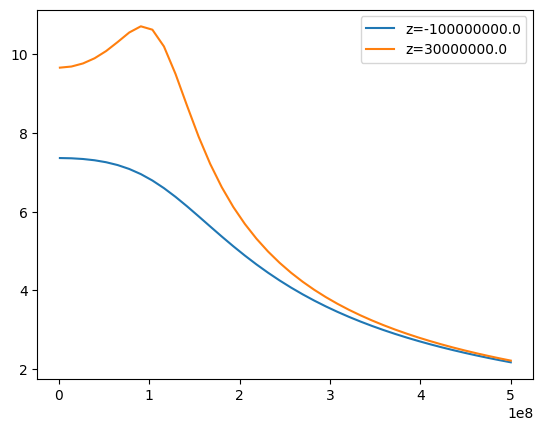

In [165]:
for k in range(0, len(z)):
    if k % 13 == 0:
        plt.plot(R, potential[:, k], label=f'z={z[k]}')

plt.legend()
plt.show()

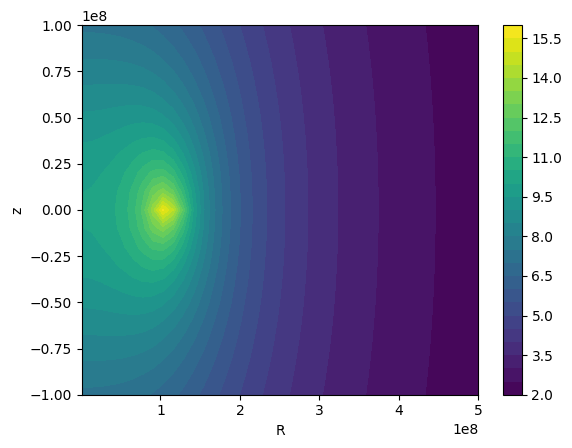

In [166]:
# plt.xticks(R[:, 0], np.arange(0, 3, 1))
# plt.yticks(z[0, :], np.arange(-10, 10, 1))
# plt.imshow(potential)

plt.xlabel('R')
plt.ylabel('z')
plt.contourf(R, z, potential.T, 30)

plt.colorbar()

plt.show()